In [1]:
import argparse
import logging
import os
import time

from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from numpyro.examples.datasets import JSB_CHORALES, load_dataset
from numpyro.handlers import mask
from numpyro.infer import HMC, MCMC, NUTS, SVI, Trace_ELBO, TraceGraph_ELBO, Predictive
from numpyro.ops.indexing import Vindex
from numpyro.infer.autoguide import AutoDelta, AutoGuide
from numpyro.optim import Adam
from pyro import poutine
from numpyro.contrib.funsor.discrete import infer_discrete
from numpyro.contrib.funsor.infer_util import config_enumerate
from numpyro.contrib.funsor.enum_messenger import markov

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

rng_key = random.PRNGKey(0)

In [2]:
def model():
    with numpyro.handlers.block(), numpyro.handlers.seed(rng_seed=rng_key):
        a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Dirichlet(concentration=jnp.array([2., 3, 4, 5, 6])))

optim = numpyro.optim.Adam(step_size=1e-3)
elbo = Trace_ELBO()
guide = AutoDelta(model)
svi = SVI(model, guide, optim, elbo)
svi_result = svi.run(rng_key, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1235.12it/s, init loss: -6.3782, avg. loss [951-1000]: -6.5432]


In [3]:
#     x[t-1] --> x[t] --> x[t+1]
#        |        |         |
#        V        V         V
#     y[t-1]     y[t]     y[t+1]
#
# This model includes a plate for the data_dim = 44 keys on the piano. This
# model has two "style" parameters probs_x and probs_y that we'll draw from a
# prior. The latent state is x, and the observed state is y.
@config_enumerate
def model_1(sequences, lengths, hidden_dim, include_prior=True):
    num_sequences, max_length, data_dim = sequences.shape
    with mask(mask=include_prior):
        probs_x = numpyro.sample(
            "probs_x", dist.Dirichlet(0.9 * jnp.eye(hidden_dim) + 0.1).to_event(1)
        )
        probs_y = numpyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2),
        )

    def transition_fn(carry, y):
        x_prev, t = carry
        with numpyro.plate("sequences", num_sequences, dim=-2):
            with mask(mask=(t < lengths)[..., None]):
                x = numpyro.sample(
                    "x",
                    dist.Categorical(probs_x[x_prev]),
                    infer={"enumerate": "parallel"},
                )
                with numpyro.plate("tones", data_dim, dim=-1):
                    numpyro.sample("y", dist.Bernoulli(probs_y[x.squeeze(-1)]), obs=y)
        return (x, t + 1), None

    x_init = jnp.zeros((num_sequences, 1), dtype=jnp.int32)
    # NB swapaxes: we move time dimension of `sequences` to the front to scan over it
    scan(transition_fn, (x_init, 0), jnp.swapaxes(sequences, 0, 1))

    
def custom_guide(sequences, lengths, hidden_dim, include_prior=True):
    num_sequences, max_length, data_dim = sequences.shape
    
    a = numpyro.param('a', 0.9 * jnp.eye(hidden_dim) + 0.1, constraint=dist.constraints.unit_interval)
    beta0 = numpyro.param('beta0', jnp.ones((hidden_dim, data_dim)) * 0.1, constraint=dist.constraints.unit_interval)
    beta1 = numpyro.param('beta1', jnp.ones((hidden_dim, data_dim)) * 0.9, constraint=dist.constraints.unit_interval)
    
    with mask(mask=include_prior):
        probs_x = numpyro.sample(
            "probs_x", dist.Dirichlet(a).to_event(1)
        )
        probs_y = numpyro.sample(
            "probs_y",
            dist.Beta(beta0, beta1).to_event(2),
        )

In [4]:

def main(num_samples=1000, hidden_dim=16, truncate=None, num_sequences=None,
         kernel='nuts', num_warmup=500, num_chains=1, device='cpu', inference='svi', guide_type='auto'):

    # model = model_1 if inference=='mcmc' else model_1_blocked
    model = model_1
    
    numpyro.set_platform(device)

    _, fetch = load_dataset(JSB_CHORALES, split="train", shuffle=False)
    lengths, sequences = fetch()
    if num_sequences:
        sequences = sequences[0 : num_sequences]
        lengths = lengths[0 : num_sequences]

    logger.info("-" * 40)
    logger.info("Training {} on {} sequences".format(model.__name__, len(sequences)))

    # find all the notes that are present at least once in the training set
    present_notes = (sequences == 1).sum(0).sum(0) > 0
    # remove notes that are never played (we remove 37/88 notes with default args)
    sequences = sequences[:, :, present_notes]

    if truncate:
        lengths = lengths.clip(0, truncate)
        sequences = sequences[:, : truncate]

    logger.info("Each sequence has shape {}".format(sequences[0].shape))
    
    if inference=='mcmc':
        
        logger.info("Starting MCMC...")
        
        kernel = {"nuts": NUTS, "hmc": HMC}[kernel](model)
        start = time.time()
        mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
            num_chains=num_chains,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
        )
        mcmc.run(rng_key, sequences, lengths, hidden_dim)
        mcmc.print_summary()
        logger.info("\nMCMC elapsed time: {}".format(time.time() - start))
        
        return mcmc
        
    elif inference=='svi':
    
        logger.info("Starting SVI...")
        
        model = numpyro.handlers.seed(model, rng_key)
        optim = Adam(step_size=1e-3)
        elbo = Trace_ELBO()
        if guide_type=='auto':
            guide = AutoDelta(
                numpyro.handlers.block(model, hide=['x', 'y'])
            )
        else:
            guide = custom_guide

        svi = SVI(model, guide, optim, loss=elbo)
        start = time.time()
        svi_result = svi.run(rng_key, 1000, sequences, lengths, hidden_dim)
        logger.info("\nSVI elapsed time: {}".format(time.time() - start))

        predictive = Predictive(guide, params=svi_result.params, num_samples=1000)
        samples = predictive(rng_key, sequences, lengths, hidden_dim)

#         pred = Predictive(
#             model=model,
#             posterior_samples=svi_result.params,
#             infer_discrete=True
#         )
#         samples = pred(
#             rng_key, sequences, lengths, hidden_dim
#         )
    
        return samples, svi_result, sequences, lengths, hidden_dim, guide



In [5]:
samples, svi_result, sequences, lengths, hidden_dim, guide = main()

INFO:__main__:----------------------------------------
INFO:__main__:Training model_1 on 229 sequences
INFO:__main__:Each sequence has shape (129, 51)
INFO:__main__:Starting SVI...
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv2/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Currently, SVI with Trace_ELBO loss does not support models with discrete latent variables
  0%|          | 0/1000 [00:00<?, ?it/s]/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv2/lib/python3.7/site-packages/jax/linear_util.py:168: UserWarning: Found vars in model but not guide: {'x'}
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 1000/1000 [00:21<00:00, 47.08it/s, init loss: 394640.3125, avg. loss [951-1000]: 344344.0000]
INFO:__main__:
SVI elapsed time: 32.283920764923096


In [6]:
samples.keys()

dict_keys(['probs_x', 'probs_y'])

In [7]:
trans_mat = np.array(samples['probs_x']).mean(axis=0)

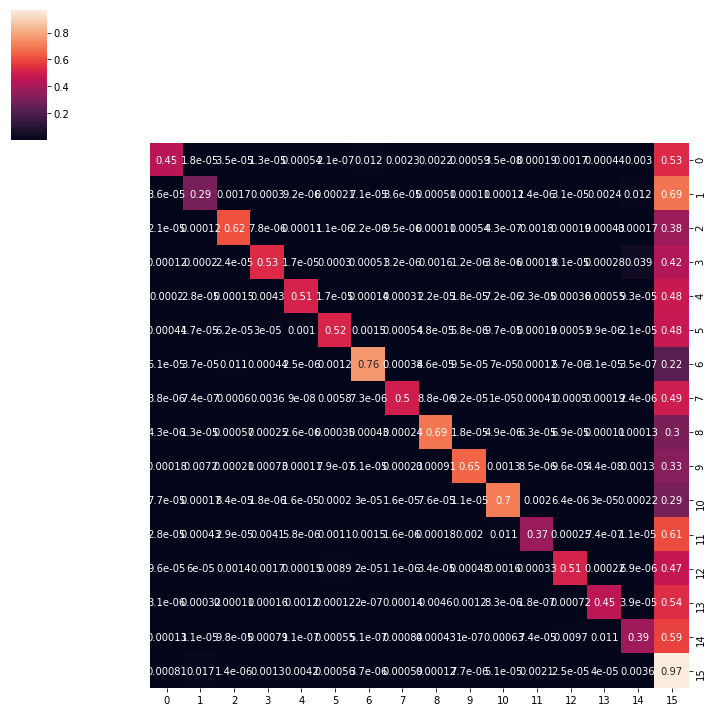

In [8]:
sns.clustermap(trans_mat, col_cluster=False, row_cluster=False, annot=True)
plt.show()

In [9]:
# mcmc_result = main(inference='mcmc')

In [10]:
# mcmc_result.get_samples()['probs_x'].shape

In [11]:
# trans_mat_mcmc = np.array(mcmc_result.get_samples()['probs_x']).mean(axis=0)

In [12]:
# sns.clustermap(trans_mat_mcmc, col_cluster=False, row_cluster=False, annot=True)
# plt.show()

In [13]:
# pred = Predictive(
#     model=numpyro.handlers.seed(model_1, rng_key),
#     posterior_samples=svi_result.params,
#     infer_discrete=True
# )

In [14]:
# pred(rng_key, sequences, lengths, hidden_dim)

In [15]:
model_trace = numpyro.handlers.trace(numpyro.handlers.seed(numpyro.handlers.condition(model_1, samples), rng_key))

### Try to use `infer_discrete`, `replay`, and `trace` to sample the discrete sites `x`

This doesn't work because `infer_discrete` does not yet support `numpyro.contrib.cocntrol_flow.scan`

In [16]:
guide_trace = numpyro.handlers.trace(guide).get_trace(sequences, lengths, hidden_dim)
trained_model = numpyro.handlers.replay(numpyro.handlers.seed(model_1, rng_key), trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-3, rng_key=rng_key)

# trace = numpyro.handlers.trace(inferred_model).get_trace(sequences, lengths, hidden_dim)

### Try to build a custom viterbi decoder that matches the model

In [17]:
svi_result.params['probs_y_auto_loc']

DeviceArray([[4.86648532e-05, 1.93663567e-04, 3.52749164e-04,
              1.95083895e-03, 5.83679765e-04, 1.41103432e-04,
              2.71544512e-03, 1.82333562e-04, 3.67115019e-03,
              4.38076630e-03, 6.20061706e-04, 1.21880905e-03,
              5.80321532e-04, 6.38501346e-03, 3.74539918e-03,
              1.34933377e-02, 1.53587200e-03, 6.15408318e-03,
              1.97173050e-03, 4.20577452e-02, 4.36234893e-03,
              3.47739924e-03, 1.37994590e-03, 6.43393546e-02,
              1.50508620e-02, 4.44715517e-03, 1.58337440e-04,
              2.12382688e-03, 4.11448011e-04, 1.33111526e-03,
              5.85142476e-03, 8.03130493e-02, 9.39614038e-05,
              8.43515545e-02, 2.04216130e-02, 4.60024166e-05,
              1.64832818e-05, 2.25296011e-04, 3.08113825e-03,
              4.82459590e-02, 1.39320614e-02, 1.79638577e-04,
              1.26808798e-02, 1.02874273e-02, 7.76363413e-06,
              1.58403050e-02, 1.18077174e-03, 9.51093909e-07,
        

In [18]:
sequences[0].astype('float32')

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 1., ..., 0., 0., 0.],
             [0., 0., 1., ..., 0., 0., 0.],
             [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [19]:
@infer_discrete(first_available_dim=-1, temperature=0, rng_key=rng_key)
@config_enumerate
def viterbi_decoder(data, hidden_dim=10):
    max_length, data_dim = data.shape
    transition = 0.3 / hidden_dim + 0.7 * jnp.eye(hidden_dim)
    # means = jnp.array([list(range(hidden_dim)), list(range(hidden_dim))]).T
    means = jnp.arange(float(hidden_dim))
    print(means)
    states = [0]
    for t in markov(range(max_length)):
        print('t', t)
        states.append(numpyro.sample("states_{}".format(t),
                                    dist.Categorical(transition[states[-1]])))
        print('states[-1]', states[-1].shape)
        print('means[states[-1]]', means[states[-1]].shape)
        print('means[states[-1]]', means[states[-1]])
        numpyro.sample("obs_{}".format(t),
                           dist.Normal(means[states[-1]], 1.),
                           obs=data[t])
    return states  # returns maximum likelihood states
    
    return xs  # returns maximum likelihood states

for i in range(1):
#     temp_data = jnp.array([[1., 1.], [1., 1.], [2., 2.], [2., 2.], [2., 2.]])
    temp_data = jnp.array([[1.], [1.], [2.], [2.], [2.]])
    print(temp_data.shape)
    xs = viterbi_decoder(temp_data)
    print(len(xs))
    print(xs)
    break

(5, 1)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
t 0
states[-1] (10,)
means[states[-1]] (10,)
means[states[-1]] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
t 1
states[-1] (10, 1)
means[states[-1]] (10, 1)
means[states[-1]] [[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]
t 2
states[-1] (10,)
means[states[-1]] (10,)
means[states[-1]] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
t 3
states[-1] (10, 1)
means[states[-1]] (10, 1)
means[states[-1]] [[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]
t 4
states[-1] (10,)
means[states[-1]] (10,)
means[states[-1]] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
t 0
states[-1] ()
means[states[-1]] ()
means[states[-1]] 0.0
t 1
states[-1] ()
means[states[-1]] ()
means[states[-1]] 0.0
t 2
states[-1] ()
means[states[-1]] ()
means[states[-1]] 2.0
t 3
states[-1] ()
means[states[-1]] ()
means[states[-1]] 2.0
t 4
states[-1] ()
means[states[-1]] ()
means[states[-1]] 2.0
6
[0, DeviceArray(0, dtype=int32), DeviceArray(0, dtype=int32), DeviceArray(2, dtyp

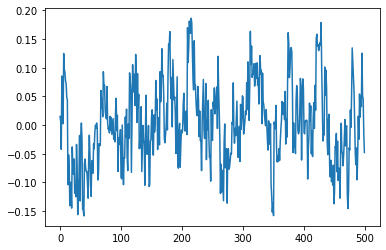

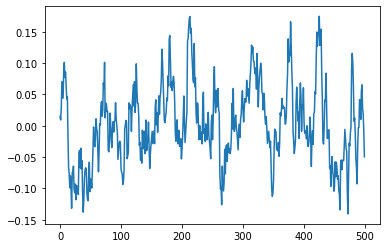

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

T = 500
N = 10

phi = 0.9
sigma_x = 0.03
sigma_y = 0.1

np.random.seed(42)

e = np.random.normal(size=T, scale=sigma_x)

x = np.empty(T)

x[0] = e[0]
for t in range(1, T):
    x[t] = x[t - 1] * phi + e[t]
    
y = x + np.random.normal(size=(N, T), scale=sigma_y)

pd.Series(y.mean(0)).plot()
plt.show()
pd.Series(x).plot()
plt.show()

In [21]:
import jax

def model(y):
    
    N, T = y.shape
    
    phi = numpyro.param('phi', jnp.array(0.0))
    sigma_x = numpyro.param('sigma_x', jnp.array(1.0), constraint=dist.constraints.positive)
    sigma_y = numpyro.param('sigma_y', jnp.array(1.0), constraint=dist.constraints.positive)
    
    def transition(x, e):
        x_new = x * phi + e
        return x_new, x_new
    
    x0 = numpyro.sample('x0', dist.Normal(np.zeros(1), sigma_x))
    e = numpyro.sample('e', dist.Normal(np.zeros(T), sigma_x))
    _, x = jax.lax.scan(transition, x0, e)
    numpyro.deterministic('x', x)
    numpyro.sample('obs', dist.Normal(x.squeeze(-1), sigma_y), obs=y)

y_jax = jnp.array(y)

guide = numpyro.infer.autoguide.AutoNormal(model)
optim = numpyro.optim.Adam(step_size=0.002)
svi = numpyro.infer.SVI(model, guide, optim, loss=numpyro.infer.Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), 10000, y_jax)

params = svi_result.params
guide_samples = guide.sample_posterior(jax.random.PRNGKey(1), svi_result.params)

print(params['phi'])
print(params['sigma_x'])
print(params['sigma_y'])

100%|██████████| 10000/10000 [00:10<00:00, 924.26it/s, init loss: 9151.4316, avg. loss [9501-10000]: -4105.5483]


0.573861
0.039156593
0.09995778


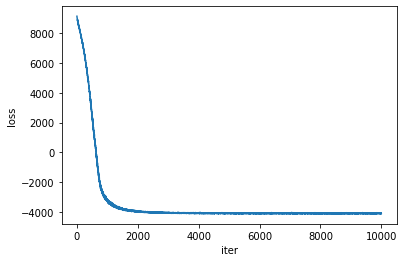

In [22]:
plt.plot(range(len(svi_result.losses)), svi_result.losses)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

In [23]:
guide_samples.keys()

dict_keys(['x0', 'e', 'x'])

In [24]:
params.keys()

dict_keys(['e_auto_loc', 'e_auto_scale', 'phi', 'sigma_x', 'sigma_y', 'x0_auto_loc', 'x0_auto_scale'])